<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [13]:
import pandas as pd
import unicodedata
df = pd.read_csv('E:/Sharpest_Mind/WikipediaCitation/notebooks/Data/wiki_data.csv', encoding = 'utf8')

df['text_new'] = (df['text_new'].map(lambda x: unicodedata.normalize('NFKD', str(x))))

df.head()

,text_new,label
0,"The close similarities between measles virus, ...",1
1,Although the main weapon used was vaccinia vir...,1
2,Other coronaviruses were known to cause mild i...,1
3,"Some zoonotic infections are often ""dead ends""...",1
4,Microorganisms constitute more than 90 per cen...,1


In [14]:
df.shape

(19998, 2)

In [15]:
# Converting the dataframe into a list of tuples
df['tuples'] = df.apply(lambda row: (row['text_new'],row['label']), axis=1)
train1=df['tuples'].tolist()
train1[19990:]

[('The Hoysala era was an important period in the development of art, architecture, and religion in South India. The empire is remembered today primarily for Hoysala architecture. Over a hundred surviving temples are scattered across Karnataka.',
  0),
 ("The Falkland Islands (/ˈfɔːlklənd/; Spanish: Islas Malvinas , pronounced [ˈislas malˈβinas]) is an archipelago in the South Atlantic Ocean on the Patagonian Shelf. The principal islands are about 300 miles (483 kilometres) east of South America's southern Patagonian coast, at a latitude of about 52°S. The archipelago, with an area of 4,700 square miles (12,000 square kilometres), comprises East Falkland, West Falkland and 776 smaller islands. As a British overseas territory, the Falklands have internal self-governance, and the United Kingdom takes responsibility for their defence and foreign affairs. The Falkland Islands' capital is Stanley on East Falkland.",
  0),
 ("Controversy exists over the Falklands' discovery and subsequent co

In [16]:

df = df[['tuples', 'label']]
df.to_csv('df_train_Wikidata.csv', index=False)

In [17]:
import spacy
nlp = spacy.load('en_core_web_sm')
# Adding the built-in textcat component to the pipeline.
textcat=nlp.create_pipe( "textcat", config={"exclusive_classes": True, "architecture": "ensemble"})
nlp.add_pipe(textcat, last=True)
nlp.pipe_names

['tagger', 'parser', 'ner', 'textcat']

In [18]:
# Adding the labels to textcat
textcat.add_label("POSITIVE")
textcat.add_label("NEGATIVE")

1

1

In [20]:
import random

def load_data( split=0.8):
    train_data=train1
    # Shuffle the data
    
    random.shuffle(train_data)
    texts, labels = zip(*train_data)
    # get the categories for each review
    cats = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in labels]

    # Splitting the training and evaluation data
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])



# Calling the load_data() function 
(train_texts, train_cats), (dev_texts, dev_cats) = load_data()

#(test_texts, test_cats), (tev_texts, devt_cats) = load_data(limit=n_texts)
# Processing the final format of training data
train_data = list(zip(train_texts,[{'cats': cats} for cats in train_cats]))
train_data[:10]
dev_data = list(zip(dev_texts,[{'cats': cats} for cats in dev_cats]))
dev_data[:10]
#test_data = list(zip(test_texts,[{'cats': cats} for cats in test_cats]))
#test_data[:10]

[('The Great North had opened using a system of telegraphic train orders, and as the signalling was being upgraded this was being replaced with electric tablet working over the single line sections',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ('Like other major rugby nations Argentina, Australia, France and South Africa, New Zealand does not have an official stadium for its national team. Instead, the All Blacks play their test matches at a variety of venues throughout New Zealand.',
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}}),
 ('Trophimowsky was an anarchist, tutor, and former Orthodox priest-turned-atheist,  and Nathalie was the illegitimate daughter of a middle-class Lutheran German and a Russian Jew',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ('Many presentations still describe Compsognathus as "chicken-sized" dinosaurs because of the small size of the German specimen, which is now believed to be a juvenile. Compsognathus longipes is one of the few dino

[(' Amphetamine is also known to increase intracellular calcium, an effect which is associated with DAT phosphorylation through an unidentified Ca2+/calmodulin-dependent protein kinase (CAMK)-dependent pathway, in turn producing dopamine efflux',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ('His past experience and the credibility derived from his time in Japan brought him a large clientele of opulent locals, posing in traditional attire for official portraits. Other images, from Buddhas to landscapes and buildings, were sold from master albums in Burma and Europe.',
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}}),
 ("Family Trade is an American reality television series broadcast by Game Show Network (GSN). The show premiered on March 12, 2013; its eighth and final episode aired on April 16, 2013. Filmed in Middlebury, Vermont, the series chronicles the daily activities of G. Stone Motors, a GMC and Ford car dealership that employs the barter system in selling its automobi

In [21]:
print(len(train_data))
#print(len(test_data))
print(len(dev_data))

15998
4000


In [22]:
def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 0.0  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 0.0  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if label == "NEGATIVE":
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.0
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.0
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if (precision + recall) == 0:
        f_score = 0.0
    else:
        f_score = 2 * (precision * recall) / (precision + recall)
    return {"textcat_a": accuracy,"textcat_p": precision, "textcat_r": recall, "textcat_f": f_score}




In [23]:
#from thinc.neural.optimizers import Adam
#from thinc.neural import Model



#nlp.begin_training()

# optimizer options. Defaults are changed where commented
#ops = Model.ops
#learn_rate = 0.001
#beta1 = 0.9
#beta2 = 0.999
#eps = 1e-8
#L2 = 1e-6
#max_grad_norm = 1.0
#optimizer = Adam(ops, learn_rate, L2=L2, beta1=beta1, beta2=beta2, eps=eps)
#optimizer.max_grad_norm = max_grad_norm

In [25]:
from spacy.util import minibatch, compounding, decaying
#("Number of training iterations", "n", int))
n_iter=5
# Disabling other components
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    optimizer.L2 = 2e-5
    dec = decaying(0.6 , 0.2, 1e-4)
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS',  'A_train', 'A_test', 'P', 'R', 'F'))
    train_results = []
    test_results = []
    # Performing training
    for i in range(n_iter):
        losses = {}
        random.shuffle(train_data)
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=next(dec),
                       losses=losses)
        # Calling the evaluate() function and printing the train scores
        scores1 = evaluate(nlp.tokenizer, textcat, train_texts, train_cats)
        train_results.append(scores1) 
      # Calling the evaluate() function and printing the test scores
        with textcat.model.use_params(optimizer.averages):
            
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        test_results.append(scores)
        print('{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}\t{5:.4f}'  
              .format(losses['textcat'],  scores1['textcat_a'], scores['textcat_a'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))



Training the model...
LOSS 	A_train	A_test	  P  	  R  	  F  
15.9112	0.9773	0.9752	0.9586	0.9941	0.9760
1.8492	0.9790	0.9757	0.9595	0.9941	0.9765
1.5058	0.9809	0.9767	0.9614	0.9941	0.9774
1.4266	0.9857	0.9767	0.9605	0.9951	0.9775
1.1055	0.9921	0.9750	0.9560	0.9965	0.9758


In [26]:
# Save model
with nlp.use_params(optimizer.averages):
    nlp.to_disk("model_artifactWikidata1")

In [28]:
# Converting the dataframe into a list of tuples
df2 = pd.read_csv('E:/Sharpest_Mind/WikipediaCitation/notebooks/Data/wiki_data_test.csv', encoding = 'utf8')

df2['statement'] = (df2['statement'].map(lambda x: unicodedata.normalize('NFKD', str(x))))

df2.head()

,statement,Label
0,"Jir Deh (Persian: جيرده‎ , also Romanized as J...",1
1,"Fajrabad (Persian: فجراباد‎ , also Romanized a...",1
2,"Saran-e Pain (Persian: ساران پائين‎ , also Ro...",1
3,"Jefrud-e Pain (Persian: جفرودپائين‎ , also Ro...",1
4,"Do Sangan (Persian: دوسنگان‎ , also Romanized ...",1


In [29]:
df2['tuples'] = df2.apply(lambda row: (row['statement'],row['Label']), axis=1)
test =df2['tuples'].tolist()
random.shuffle(test)
test_text, test_label = zip(*test)

In [30]:

df2 = df2[['tuples', 'Label']]

In [32]:
# evaluate the model on test data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
loaded_model = spacy.load("model_artifactWikidata1")

test_docs = list(loaded_model.pipe(test_text))
textcat = loaded_model.get_pipe('textcat')

scores, _ = textcat.predict(test_docs)
predicted_clases = scores.argmax(axis=1)
correct_predictions = predicted_clases==test_label

print("F1 score=", f1_score(predicted_clases,test_label))
print("ROC AUC score = ", roc_auc_score(test_label, predicted_clases))
print("Accuracy = ", accuracy_score(test_label, predicted_clases))
print("Confusion Matrix = ", confusion_matrix(test_label, predicted_clases))


F1 score= 0.009267643142476696
ROC AUC score =  0.06907340869343925
Accuracy =  0.06901901901901902
Confusion Matrix =  [[1292 8689]
 [9912   87]]


Test accuracy using evaluate function below

In [38]:
random.shuffle(test)
test_texts1, test_cats1 = zip(*test[:4000])
 # get the categories for each review
test_cats1 = [{"POSITIVE": bool(y), "NEGATIVE": not bool(y)} for y in test_cats1]
test_data1 = list(zip(test_texts1,[{'cats': cats} for cats in test_cats1]))
test_data1[:2]



[('Controlling for relevant factors, the authors found that "Muslim immigrants living in states with the sharpest increase in hate crimes also exhibit: greater chances of marrying within their own ethnic group; higher fertility; lower female labour force participation; and lower English proficiency." A study of Germans found that the 9/11 terror attacks contributed to greater anti-immigrant sentiments',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ("It sets apart the Gorgan Bay from the Caspian Sea. The elevation of the peninsula from the sea level is 23 meters and four villages are situated on it namely: Ashuradeh, Qezel-e shomali, Qezel-Mehdi and Qavasatl.The city situated at the opposite side of the peninsula's end is Bandar Torkaman. The island of Ashuradeh lies off the eastern tip of the peninsula. The peninsula is located in Behshahr County.",
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}})]

In [39]:
test_data = list(zip(test_texts1,[{'cats': cats} for cats in test_cats1]))
test_data[1:10]

[("It sets apart the Gorgan Bay from the Caspian Sea. The elevation of the peninsula from the sea level is 23 meters and four villages are situated on it namely: Ashuradeh, Qezel-e shomali, Qezel-Mehdi and Qavasatl.The city situated at the opposite side of the peninsula's end is Bandar Torkaman. The island of Ashuradeh lies off the eastern tip of the peninsula. The peninsula is located in Behshahr County.",
  {'cats': {'POSITIVE': False, 'NEGATIVE': True}}),
 ('Zarandin-e Sofla (Persian: زرندين سفلي\u200e , also Romanized as Zarandīn-e Soflá; also known as Pā’īn Zarandīn and Zarandīn-e Pā’īn) is a village in Peyrajeh Rural District, in the Central District of Neka County, Mazandaran Province, Iran',
  {'cats': {'POSITIVE': True, 'NEGATIVE': False}}),
 ('The entire lake, the bogs around its shores and a 100-metre-wide strip of the wood surrounding the lake are designated as a core zone of the Southeast Rügen Biosphere Reserve. That said, the lake is accessible to hikers and cyc

In [43]:
loaded_model = spacy.load("model_artifactWikidata1")
textcat2 = loaded_model.get_pipe('textcat')
scores2= evaluate(loaded_model, textcat2, test_texts1, test_cats1)

In [44]:
scores2

{'textcat_a': 0.9287499999953563,
 'textcat_p': 0.8814387211328534,
 'textcat_r': 0.9910134797753819,
 'textcat_f': 0.9330199764938518}

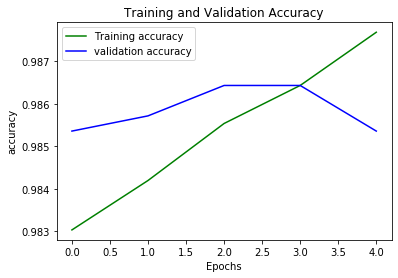

In [29]:
import matplotlib.pyplot as plt

accuracy_train = [(d['textcat_a']) for d in train_results]
accuracy_val = [(d['textcat_a']) for d in test_results]
epochs = range(0,5)
plt.plot(epochs, accuracy_train, 'g', label='Training accuracy')
plt.plot(epochs, accuracy_val, 'b', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [62]:
# Testing the model = 
test_text= "Such positions also allowed him to play a central role in training the militia forces who repelled the Bay of Pigs Invasion and bringing the Soviet nuclear-armed ballistic missiles to Cuba which precipitated the 1962 Cuban Missile Crisis "
doc=nlp(test_text)
doc.cats

{'POSITIVE': 0.9963908791542053, 'NEGATIVE': 0.003609072184190154}

In [58]:
# Testing the model
test_text="Later, during the Age of Exploration, maps became progressively more accurate for navigation needs and were often sprinkled with sketches and drawings such as sailing ships showing the direction of trade winds, little trees and mounds to represent forests and mountains and of course, plenty of sea creatures and exotic natives much of them imaginary. As the need for geographical accuracy increased, these illustrations gradually slipped off the map and onto the borders and eventually disappeared altogether in the wake of modern scientific cartography."
doc=nlp(test_text)
doc.cats

{'POSITIVE': 0.0021363908890634775, 'NEGATIVE': 0.9978635907173157}

In [ ]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from spacy.util import load_model_from_path
from os.path import join, dirname, abspath
from sentipy.utils import process_patterns
import matplotlib.pyplot as plt
import click
import streamlit.cli

In [36]:
df.head()

,tuples,label
0,"(The close similarities between measles virus,...",1
1,(Although the main weapon used was vaccinia vi...,1
2,(Other coronaviruses were known to cause mild ...,1
3,"(Some zoonotic infections are often ""dead ends...",1
4,(Microorganisms constitute more than 90 per ce...,1


In [44]:
import numpy as np
import pandas as pd
from lime.lime_text import LimeTextExplainer
from spacy.util import load_model_from_path
from os.path import join, dirname, abspath

import matplotlib.pyplot as plt
import click
import streamlit.cli

In [45]:
import spacy


# Load model
citation_model = spacy.load('model_artifactWikidata')

# Load airline CSV
df1 = pd.read_csv('wiki_data.csv', encoding = 'utf8')

df1['text_new'] = (df1['text_new'].map(lambda x: unicodedata.normalize('NFKD', str(x))))

train_df = df1[['text_new', 'label']]
cats = list(train_df['label'].unique())

arr_len = len(cats)

# Initialize LIME text explainer
explainer = LimeTextExplainer(class_names=cats)




In [55]:
def predict_prob(context):
    """
    Provideds sklearn style predict_proba output
    Params:
    -------
    context: str - text content to evaluate
    Returns:
    --------
    numpy array of probabilities
    """

    fin_arr = np.zeros(shape=(1, arr_len))

    for txt in context:
        doc = citation_model(txt)
        preds = np.array(list(doc.cats.values())).reshape(1, arr_len)
        fin_arr = np.vstack((fin_arr, preds))

    return fin_arr[1:]


def explain_text_features(context, viz_features):
    """
    Explains the mot important features of text
    Params:
    -------
    context: str - text content to evaluate
    viz_features: int - Number of features to visualize. Defaults to 5
    Returns:
    --------
    Explanation of features for class
    """

    # Print predicted class
    doc = citation_model(context)
    outcome = max(doc.cats, key=doc.cats.get)
    # print(f'Predicted class - {outcome}\n')

    # Initialize explainer
    exp = explainer.explain_instance(context, predict_prob, labels=[0, 1],
                                     num_features=viz_features)

    # Initialize a matpotlib figure
    fig = plt.figure(figsize=(15, 20))

    # Create subplot for Neutral
    plt.subplot(2, 1, 1)
    plt.title('Features contribution for class Neutral', fontsize=21,
              color='blue')
    neu_values = [i[1] for i in exp.as_list(label=0)]
    neu_words = [i[0] for i in exp.as_list(label=0)]
    neu_colors = ['green' if x > 0 else 'red' for x in neu_values]
    plt.barh(y=neu_words, width=neu_values, align='center', color=neu_colors)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # Create subplot for Positive
    plt.subplot(2, 1, 2)
    plt.title('Features contribution for class Positive', fontsize=21,
              color='blue')
    pos_values = [i[1] for i in exp.as_list(label=1)]
    pos_words = [i[0] for i in exp.as_list(label=1)]
    pos_colors = ['green' if x > 0 else 'red' for x in pos_values]
    plt.barh(y=pos_words, width=pos_values, align='center', color=pos_colors)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    

    # Create a Super Title
    plt.suptitle('Classwise most important features', fontsize=34,
                 color='navy')

    return outcome, fig


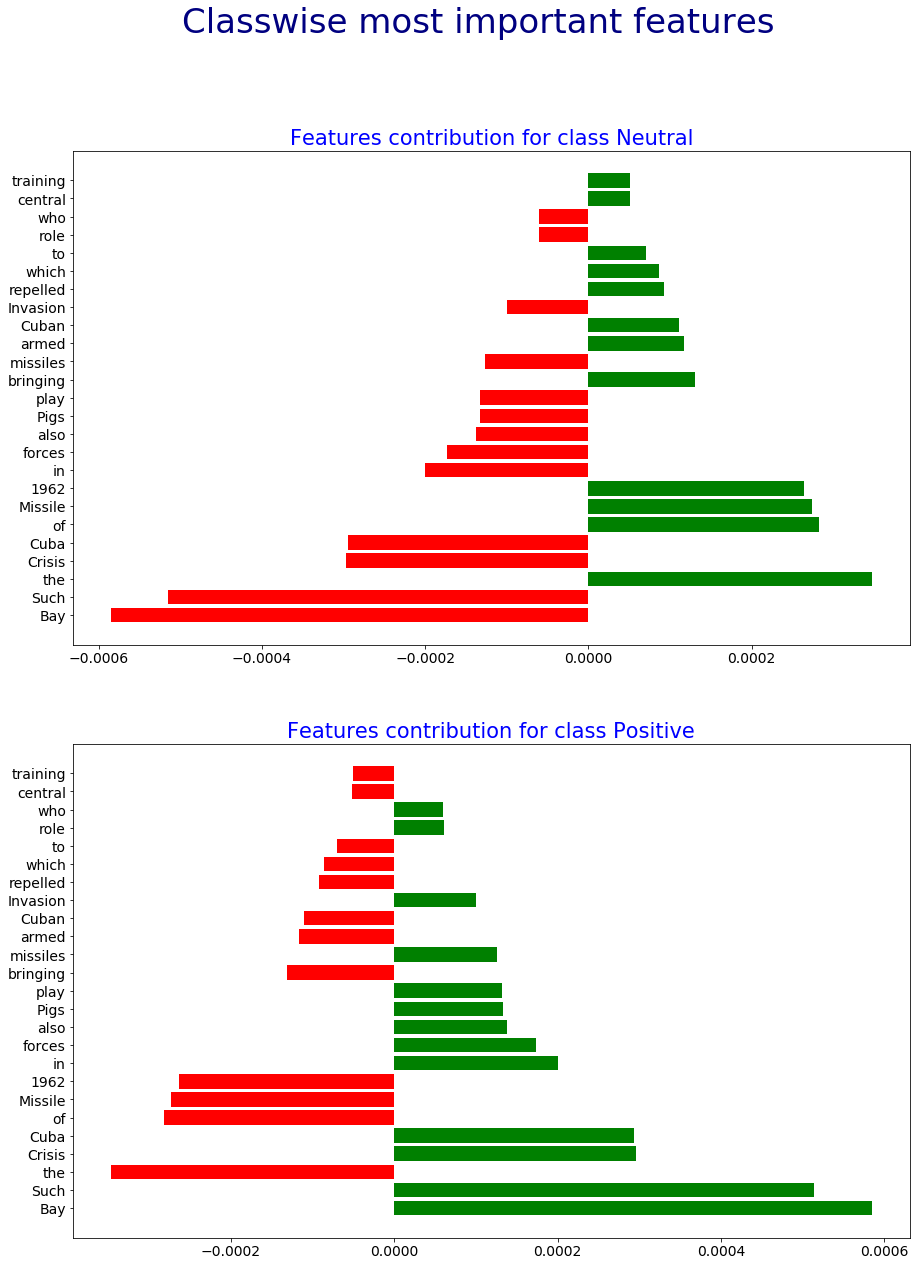

In [61]:
#context = 'Later, during the Age of Exploration, maps became progressively more accurate for navigation needs and were often sprinkled with sketches and drawings such as sailing ships showing the direction of trade winds, little trees and mounds to represent forests and mountains and of course, plenty of sea creatures and exotic natives much of them imaginary. As the need for geographical accuracy increased, these illustrations gradually slipped off the map and onto the borders and eventually disappeared altogether in the wake of modern scientific cartography.'
context ='Such positions also allowed him to play a central role in training the militia forces who repelled the Bay of Pigs Invasion and bringing the Soviet nuclear-armed ballistic missiles to Cuba which precipitated the 1962 Cuban Missile Crisis'
feature_ex = explain_text_features(context, 25)

In [ ]:
'The Hoysala era was an important period in the development of art, architecture, and religion in South India. The empire is remembered today primarily for Hoysala architecture. Ove'r a hundred surviving temples are scattered across Karnataka.